<a href="https://colab.research.google.com/github/fquinterov/FPP-Blender/blob/main/Phase_Extraction_and_Unwrapping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Phase Extraction and Unwrapping**
---
Code by Fernando Quintero.  11/nov/2021

#### **1. Import libraries and declare functions.** <a name="importlib"></a>
First we import the `opencv`, `matplotlib`, `numpy`, and `pandas` libraries. If you are not using **Google Colab** make sure you have them installed in your version of Python 3.x for the correct operation of the notebook.

In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np 
from scipy.ndimage import gaussian_filter1d
from skimage.measure import profile_line
import scipy.linalg
from math import radians

def scale_range (input, min, max):
    input += -(np.min(input))
    input /= np.max(input) / (max - min)
    input += min
    return input

#### **2. Phase extraction** <a name="pextraction"></a>
For phase extraction, the phase shifting technique is implemented in its general form. This technique allows to obtain the phase $\phi(x,y)$ of a set of N images of projected sinusoidal fringes, knowing the phase shifts $\varphi _k$ and the intensity $I_k$ in each pixel of the N images by means of the following expression for a k-th shift:

$$
I_k = a + bcos[\phi(x,y) - \varphi _k]
$$

The solution of the system is simplified in the following expression to calculate the phase $\phi(x,y)$.:

$$
\phi(x,y) = -arctan(\frac{\sum_{k=1}^{N} I_k sin(\varphi_{k})}{\sum_{k=1}^{N} I_k cos(\varphi_{k})})
$$

The following script shows the example for a phase shifting of 5 fringe images. In the `pitch` variable the periods of the generated fringes must be entered, because the method for phase shifting is by binary coding which will be explained in the next section. Then with a for cycle the images with the phase shifts are read and then the expression to calculate the phase $\phi(x,y)$ is applied.

In [4]:
pitch=[1280,640,320,160,80,40,20]
plen=np.size(pitch)
wp=np.empty([plen,1024,1280,3])
ftype = '.png'

for i in range(plen):
    i1 = np.double(cv.imread('/content/v_' + str(pitch[i]) + '_1' + ftype))
    i2 = np.double(cv.imread('/content/v_' + str(pitch[i]) + '_2' + ftype))
    i3 = np.double(cv.imread('/content/v_' + str(pitch[i]) + '_3' + ftype))
    i4 = np.double(cv.imread('/content/v_' + str(pitch[i]) + '_4' + ftype))
    i5 = np.double(cv.imread('/content/v_' + str(pitch[i]) + '_5' + ftype))

    ICN = i1*np.cos(0)+i2*np.cos(2*np.pi/5)+i3*np.cos(4*np.pi/5)+i4*np.cos(6*np.pi/5)+i5*np.cos(8*np.pi/5)
    ISN = i1*np.sin(0)+i2*np.sin(2*np.pi/5)+i3*np.sin(4*np.pi/5)+i4*np.sin(6*np.pi/5)+i5*np.sin(8*np.pi/5)
    phase = -np.arctan2(ISN,ICN)
    cv.imwrite('./phase_' + str(pitch[i]) +  '.bmp',phase)
    wp[i] = phase

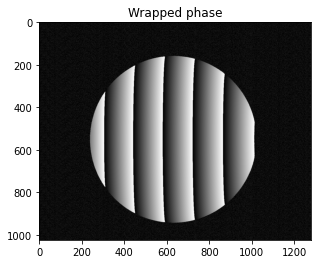

In [6]:
plt.imshow(scale_range(wp[4].copy(), 0, 255)/255)
plt.title('Wrapped phase')
plt.show()

#### **3. Phase unwrapping** <a name="punwrapping"></a>

Phase shifting technique recover a discontinuous phase φ(x, y), wrapped between (-π, π), with 2π discontinuities. For the 3D analysis it is necessary to obtain a continuous phase, which does not present ambiguities in the values. En este notebook binary coding time-phase unwrapping technique implemented which consists of projecting and capturing fringe patterns with base frequencies of base frequency 2 ($2^k$). The pseudocode for the implementation of the technique is shown below.

> ##### **Algorithm 1: Unwrapping algorithm by binary coding.**
**Input:** Discontinuous phases: $\phi _k$\
**Output:** Absolute Continuous Phase: $\Phi _a$
1.   Initialize $\phi _k$
2.   **for k = 1:K do**
3.   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\Delta_{\phi} = \phi_k  - \phi_{k-1}$
4.   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\Phi_a = \Phi_a + \Delta_{\phi} + 2\pi$ round$(\frac{\Phi_a - \Delta_{\phi}}{2\pi})$
5.   **end**

And the script of the phase development of the time-temportal phase by geometrical constraints is as follows:

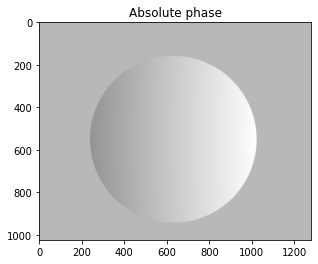

In [5]:
ap = wp[0]
for k in range(1,plen):
    deltap = wp[k] - wp[k - 1]
    ap = ap + deltap + 2*np.pi*(np.round_((ap - deltap)/(2*np.pi)))

plt.imshow(scale_range(ap.copy(), 0, 255)/255)
plt.title('Absolute phase')
import scipy.io
scipy.io.savemat('phase.mat', {'phase': ap})

# read absolute phase
phase = ap[:,:,0]
phase = phase*20/(2*np.pi) + 640